In [0]:
!pip install torchvision==0.2.1
!pip install pillow==4.2.0

    100% |████████████████████████████████| 61kB 2.3MB/s 
    100% |████████████████████████████████| 519.5MB 37kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x59776000 @  0x7f62790a81c4 0x46d6a4 0x5fcbcc 0x4c494d 0x54f3c4 0x553aaf 0x54e4c8 0x54f4f6 0x553aaf 0x54efc1 0x54f24d 0x553aaf 0x54efc1 0x54f24d 0x553aaf 0x54efc1 0x54f24d 0x551ee0 0x54e4c8 0x54f4f6 0x553aaf 0x54efc1 0x54f24d 0x551ee0 0x54efc1 0x54f24d 0x551ee0 0x54e4c8 0x54f4f6 0x553aaf 0x54e4c8
    100% |████████████████████████████████| 2.0MB 5.4MB/s 
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0
    100% |████████████████████████████████| 5.8MB 926kB/s 
  Found existing installation: Pillow 5.2.0
    Uninstalling Pillow-5.2.0:
      Successfully uninstalled Pillow-5.2.0


In [1]:
import torch
torch.__version__

'0.4.1'

In [0]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt

# CIFAR10をMLPで画像分類

## データの読み込み

In [3]:
train_dataset = torchvision.datasets.CIFAR10(root='./data/',
                                             train=True, 
                                             transform=transforms.ToTensor(),
                                             download=True)
test_dataset = torchvision.datasets.CIFAR10(root='./data/',
                                             train=False, 
                                             transform=transforms.ToTensor(),
                                             download=True)

Files already downloaded and verified


In [4]:
image, label = train_dataset[0]
print (image.size())
print (label)

torch.Size([3, 32, 32])
6


In [0]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=64, 
                                           shuffle=True,
                                          num_workers=2)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                           batch_size=64, 
                                           shuffle=False,
                                         num_workers=2)


In [8]:
for images, labels in train_loader:
    print(images.size())
    print(images[0].size())
    print(labels.size())
    # ここに訓練用のコードを書く
    break

torch.Size([64, 3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([64])


## ネットワークを定義

In [0]:
num_classes = 10

class MLPNet (nn.Module):
    def __init__(self):
        super(MLPNet, self).__init__()
        self.fc1 = nn.Linear(32 * 32 * 3, 600)
        self.fc2 = nn.Linear(600, 600)
        self.fc3 = nn.Linear(600, num_classes)
        self.dropout1 = nn.Dropout2d(0.2)
        self.dropout2 = nn.Dropout2d(0.2)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x= self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        return self.fc3(x)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
net = MLPNet().to(device)

## 損失関数と最適化関数

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

## 訓練

In [8]:
#50エポック
num_epochs = 50

#最後にlossとaccuracyのグラフをプロットするためのリスト
train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []

for epoch in range(num_epochs):
    #エポックごとに初期化
    train_loss = 0
    train_acc = 0
    val_loss = 0
    val_acc = 0
    
    #train==============================
    #訓練モードへ切り替え
    net.train()
    #ミニバッチで分割して読み込む
    for i, (images, labels) in enumerate(train_loader):
      #viewで縦横32ピクセルで3チャンネルの画像を１次元に変換
      #toでgpuに転送
      images, labels = images.view(-1, 32*32*3).to(device), labels.to(device)

      #勾配をリセット
      optimizer.zero_grad()
      #順伝播の計算
      outputs = net(images)
      #lossの計算
      loss = criterion(outputs, labels)
      #lossのミニバッチ分を溜め込む
      train_loss += loss.item()
      #accuracyをミニバッチ分を溜め込む
      #正解ラベル（labels）と予測値のtop1（outputs.max(1)）が合っている場合に1が返ってきます。
      train_acc += (outputs.max(1)[1] == labels).sum().item()
      #逆伝播の計算
      loss.backward()
      #重みの更新
      optimizer.step()
    #平均lossと平均accuracyを計算
    avg_train_loss = train_loss / len(train_loader.dataset)
    avg_train_acc = train_acc / len(train_loader.dataset)
    
    #val==============================
    #評価モードへ切り替え
    net.eval()
    #評価するときに必要のない計算が走らないようにtorch.no_gradを使用しています。
    with torch.no_grad():
      for images, labels in test_loader:        
        images, labels = images.view(-1, 32*32*3).to(device), labels.to(device)
        outputs = net(images)
        loss = criterion(outputs, labels)
        val_loss += loss.item()
        val_acc += (outputs.max(1)[1] == labels).sum().item()
    avg_val_loss = val_loss / len(test_loader.dataset)
    avg_val_acc = val_acc / len(test_loader.dataset)
    
    #訓練データのlossと検証データのlossとaccuracyをログで出しています。
    print ('Epoch [{}/{}], Loss: {loss:.4f}, val_loss: {val_loss:.4f}, val_acc: {val_acc:.4f}' 
                   .format(epoch+1, num_epochs, i+1, loss=avg_train_loss, val_loss=avg_val_loss, val_acc=avg_val_acc))
    #最後にグラフをプロットするようにリストに格納
    train_loss_list.append(avg_train_loss)
    train_acc_list.append(avg_train_acc)
    val_loss_list.append(avg_val_loss)
    val_acc_list.append(avg_val_acc)

Epoch [1/50], Loss: 0.0299, val_loss: 0.0277, val_acc: 0.3466
Epoch [2/50], Loss: 0.0273, val_loss: 0.0262, val_acc: 0.4079
Epoch [3/50], Loss: 0.0264, val_loss: 0.0251, val_acc: 0.4357
Epoch [4/50], Loss: 0.0257, val_loss: 0.0245, val_acc: 0.4439
Epoch [5/50], Loss: 0.0252, val_loss: 0.0248, val_acc: 0.4285
Epoch [6/50], Loss: 0.0247, val_loss: 0.0242, val_acc: 0.4520
Epoch [7/50], Loss: 0.0243, val_loss: 0.0235, val_acc: 0.4637
Epoch [8/50], Loss: 0.0240, val_loss: 0.0235, val_acc: 0.4610
Epoch [9/50], Loss: 0.0236, val_loss: 0.0237, val_acc: 0.4600
Epoch [10/50], Loss: 0.0234, val_loss: 0.0229, val_acc: 0.4776
Epoch [11/50], Loss: 0.0232, val_loss: 0.0222, val_acc: 0.5058
Epoch [12/50], Loss: 0.0229, val_loss: 0.0229, val_acc: 0.4745
Epoch [13/50], Loss: 0.0227, val_loss: 0.0226, val_acc: 0.4883
Epoch [14/50], Loss: 0.0225, val_loss: 0.0222, val_acc: 0.4836
Epoch [15/50], Loss: 0.0224, val_loss: 0.0221, val_acc: 0.4935
Epoch [16/50], Loss: 0.0222, val_loss: 0.0226, val_acc: 0.4859
E

## 結果をプロット

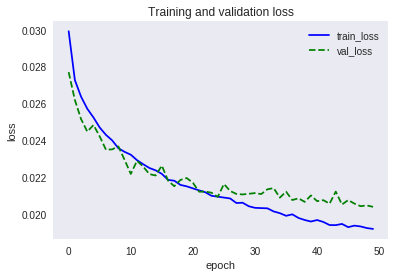

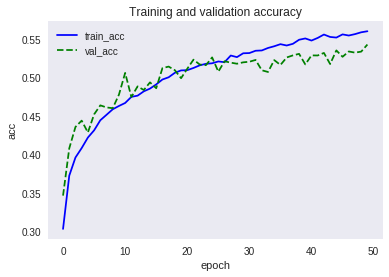

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()
plt.plot(range(num_epochs), train_loss_list, color='blue', linestyle='-', label='train_loss')
plt.plot(range(num_epochs), val_loss_list, color='green', linestyle='--', label='val_loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training and validation loss')
plt.grid()

plt.figure()
plt.plot(range(num_epochs), train_acc_list, color='blue', linestyle='-', label='train_acc')
plt.plot(range(num_epochs), val_acc_list, color='green', linestyle='--', label='val_acc')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('acc')
plt.title('Training and validation accuracy')
plt.grid()

In [0]:
# ネットワークを保存する
torch.save(net.state_dict(), 'net.ckpt')

In [0]:
# ネットワークを読み込む
net2 = MLPNet().to(device)
net2.load_state_dict(torch.load('net.ckpt'))

## 推論

In [25]:
net2.eval()
with torch.no_grad():
    total = 0
    test_acc = 0
    for images, labels in test_loader:        
        images, labels = images.view(-1, 32*32*3).to(device), labels.to(device)
        outputs = net2(images)
        test_acc += (outputs.max(1)[1] == labels).sum().item()
        total += labels.size(0)
    print('精度: {} %'.format(100 * test_acc / total)) 

精度: 54.26 %
